In [1]:
#from datasets import load_dataset
import pandas as pd
import sys
import os

### Read the csv file

In [2]:
dir = r'C:\Users\ngoth\OneDrive - flsouthern.edu\Research\AI4AD_Speech\TAUKADIAL\TAUKADIAL-24-test\TAUKADIAL-24\test'
filename = os.path.join(dir, 'testgroundtruth.csv')

In [61]:
test_df = pd.read_csv(filename, sep=';')
test_df.head(10)

,tkdname,mmse,dx
0,taukdial-001-1.wav,27,NC
1,taukdial-001-2.wav,27,NC
2,taukdial-001-3.wav,27,NC
3,taukdial-010-1.wav,27,MCI
4,taukdial-010-2.wav,27,MCI
5,taukdial-010-3.wav,27,MCI
6,taukdial-012-1.wav,29,NC
7,taukdial-012-2.wav,29,NC
8,taukdial-012-3.wav,29,NC
9,taukdial-013-1.wav,28,MCI


### Explore Test dataframe

In [4]:
example = test_df.loc[0:5, ["tkdname", "dx"]]
example

,tkdname,dx
0,taukdial-001-1.wav,NC
1,taukdial-001-2.wav,NC
2,taukdial-001-3.wav,NC
3,taukdial-010-1.wav,MCI
4,taukdial-010-2.wav,MCI
5,taukdial-010-3.wav,MCI


### Play an audio

In [5]:
import gradio as gr
import scipy.io.wavfile as wavfile
#from scipy.signal import resample
from librosa import  resample, load

""" def resample_audio(array, sampling_rate):
    num_samples = int(len(array) * float(16000) / sampling_rate)
    array = resample(array, num_samples)
    sampling_rate = 16000
    return array, sampling_rate """

def generate_audio():
    example = test_df.loc[0, ["tkdname", "dx"]].to_dict()
    array, sampling_rate = load(os.path.join(dir, example["tkdname"]), sr=None)
    print('sampling rate:', sampling_rate)
    print('array:', array)
    print('length:', len(array))
    if sampling_rate != 16000:
        array = resample(array, orig_sr=sampling_rate, target_sr=16000)
        sampling_rate = 16000
        print('new array:', array)
        print('new length:', len(array))  
        print('new sampling rate:', sampling_rate)
      
    return (
        sampling_rate,
        array,
    ), example["dx"]


with gr.Blocks() as demo:
    with gr.Column():
        for _ in range(1):
            audio, label = generate_audio()
            output = gr.Audio(audio, label=label)

demo.launch(debug=True)

c:\Users\ngoth\miniconda3\envs\pyml-book\Lib\site-packages\gradio\processing_utils.py:738: UserWarning: Trying to convert audio automatically from float32 to 16-bit int format.
  warnings.warn(warning.format(data.dtype))


sampling rate: 48000
array: [-0.01504517 -0.01509094 -0.01547241 ... -0.0065918  -0.00686646
 -0.00715637]
length: 858913
new array: [-0.00988969 -0.0171406  -0.01512437 ... -0.00557384 -0.00704113
  0.        ]
new length: 286305
new sampling rate: 16000
* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Keyboard interruption in main thread... closing server.


### Initialize feature extractor

In [6]:
from transformers import AutoFeatureExtractor

In [7]:
model_id = "ntu-spml/distilhubert"
feature_extractor = AutoFeatureExtractor.from_pretrained(model_id, do_normalize=True, return_attention_mask=True)

In [8]:
sampling_rate = feature_extractor.sampling_rate
sampling_rate

16000

In [63]:
label2id = {label: i for i, label in enumerate(test_df["dx"].unique())}
id2label = {i: label for label, i in label2id.items()}
print(f'label2id: {label2id}')
print(f'id2label: {id2label}')

label2id: {'NC': 0, 'MCI': 1}
id2label: {0: 'NC', 1: 'MCI'}


In [10]:
max_duration = 30.0

### Create a custom Dataset and Dataloader

In [64]:
import torch
from torch.utils.data import Dataset

class AudioDataset(Dataset):
    def __init__(self, data, labels):
        """
        Args:
            data (array-like): The input data.
            labels (array-like): The labels corresponding to the data.
        """
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        array, sampling_rate =  load(os.path.join(dir, self.data[idx]), sr=None)
        #print('sampling rate:', sampling_rate)
        if sampling_rate != 16000:
            array = resample(array, orig_sr=sampling_rate, target_sr=16000)
            sampling_rate = 16000
        inputs = feature_extractor(
            array,
            sampling_rate=sampling_rate,
            max_length=int(feature_extractor.sampling_rate * max_duration),
            truncation=True,
            padding="max_length",
            return_attention_mask=True,
        )
        label = label2id[self.labels[idx]]
        return inputs, label

# Example usage:
test_data = test_df["tkdname"] # Load your data here
test_labels = test_df["dx"] # Load your labels here
test_dataset = AudioDataset(test_data, test_labels)
test_dataset_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

In [12]:
test_dataset[3][0]['input_values'][0]

array([ 2.3493408e-03, -9.5359515e-04,  9.4110658e-03, ...,
       -6.1296177e-01, -9.6241987e-01, -1.5171903e+00], dtype=float32)

In [13]:
print(test_dataset[2][0]['input_values'][0].size)

480000


In [14]:
print(len(test_dataset))

120


In [15]:
print(next(iter(test_dataset_dataloader)))

[{'input_values': [tensor([[ 0.1522,  0.2561,  0.2258,  ...,  0.2291,  0.2204,  0.2213],
        [ 0.0075,  0.0018, -0.0039,  ..., -0.2242, -0.2040, -0.2300],
        [-0.0009, -0.0009, -0.0009,  ...,  0.0267,  0.0283,  0.0289],
        [-0.2964, -0.5448, -0.5291,  ...,  0.2162,  0.2156,  0.2202]])], 'attention_mask': [tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)]}, tensor([1, 1, 0, 0])]


In [16]:
data, labels = next(iter(test_dataset_dataloader))
#data = sample_batch[0]
#labels = sample_batch[1]
for k, v in data.items():
    print(f"{k}: {v}")
print(f"labels: {labels}")

input_values: [tensor([[ 0.1693,  0.2805,  0.2403,  ...,  0.4438,  0.4428,  0.4404],
        [-0.0103, -0.0184, -0.0146,  ...,  1.0376,  0.3517, -0.3808],
        [-0.0501, -0.0784, -0.0620,  ...,  1.0306,  1.0188,  1.0133],
        [-0.0189, -0.0357, -0.0239,  ..., -0.1718, -0.1677, -0.1545]])]
attention_mask: [tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)]
labels: tensor([0, 0, 1, 1])


In [17]:
import numpy as np
sample = test_dataset[0]
print(f'Mean: {np.mean(sample[0]["input_values"]):.3}, Variance: {np.var(sample[0]["input_values"]):.3}')

Mean: -1.34e-09, Variance: 0.596


### Initialize model for audio classification

In [18]:
from transformers import AutoModelForAudioClassification

In [19]:
num_labels = len(id2label)
num_labels

2

In [41]:
model = AutoModelForAudioClassification.from_pretrained(
    model_id,
    num_labels=num_labels,
    label2id = label2id,
    id2label = id2label
)

Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at ntu-spml/distilhubert and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
from huggingface_hub import notebook_login

notebook_login()

In [31]:
import evaluate
import numpy as np

metric = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [32]:
import torch
torch.cuda.is_available()

True

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [34]:
# Helper function to check GPU memory usage
def print_gpu_memory():
    print(f"Allocated memory: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Cached memory: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

In [48]:
print_gpu_memory()

Allocated memory: 73.25 MB
Cached memory: 158.00 MB


In [36]:
torch.cuda.empty_cache()

In [37]:
print_gpu_memory()

Allocated memory: 14.65 MB
Cached memory: 20.00 MB


In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from datasets import load_metric

In [71]:
# Assuming CustomDataset is already defined and data is loaded
# dataset = CustomDataset(data, labels)
# dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


# Initialize model, loss function, and optimizer
#input_size = 10  # Example input size
from multiprocessing import process
from tkinter import Y
from tkinter.filedialog import test
from idna import valid_contextj
from torch import mode


num_classes = 2  # Example number of classes
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-5)

model_save_path = './trained models/mci model 85 acc.pth'
model.load_state_dict(torch.load(model_save_path))
model.to(device)

model.eval()
print(f"Model loaded from {model_save_path}")

# Load accuracy metric
test_loss = 0.0
predictions = []
true_labels = []

with torch.no_grad():
    with tqdm(test_dataset_dataloader, unit="batch") as tepoch:
        for data, labels in tepoch:
            tepoch.set_description(f"Testing")
            data["input_values"] = data["input_values"][0]
            data["attention_mask"] = data["attention_mask"][0]
            print('data:', data)
            print('labels:', labels)
            data, labels = data.to(device), labels.to(device)

            # Forward pass
            outputs = model(input_values=data["input_values"], attention_mask=data["attention_mask"], labels=labels)
            print('outputs:', outputs)
            #loss = criterion(outputs.logits, labels)
            loss = outputs.loss
            test_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs.logits, 1)
            print('predicted:', predicted)
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

            #accuracy = 100 * correct / total
            #tepoch.set_postfix(loss=loss.item())
# Compute and print accuracy at the end of the epoch
test_loss /= len(test_dataset_dataloader)

from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, f1_score, precision_score, recall_score

# Assuming you have y_true (true labels) and y_pred (predicted labels):
y_true = true_labels
y_pred = predictions

# Accuracy
accuracy = accuracy_score(y_true, y_pred)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

# Sensitivity (Recall)
sensitivity = tp / (tp + fn)

# Specificity
specificity = tn / (tn + fp)

# F1-score
f1 = f1_score(y_true, y_pred)

# AUC-ROC
auc = 0#roc_auc_score(y_true, y_pred_proba[:, 1]) # For binary classification, use probabilities of positive class

# Precision and Recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

test_results = {}
test_results["accuracy"] = accuracy
test_results["sensitivity"] = sensitivity
test_results["specificity"] = specificity
test_results["f1"] = f1
test_results["roc_auc"] = auc
test_results["precision"] = precision
test_results["recall"] = recall

print(f"Testing Loss: {test_loss:.4f}, Testing Results: Acc {test_results['accuracy'] * 100:.2f}%, \
      Sensitivity {test_results['sensitivity'] * 100:.2f}%, Specificity {test_results['specificity'] * 100:.2f}%, \
        F1 {test_results['f1'] * 100:.2f}%, ROC AUC {test_results['roc_auc'] * 100:.2f}%, \
            Precision {test_results['precision'] * 100:.2f}%, Recall {test_results['recall'] * 100:.2f}%")

    

C:\Users\ngoth\AppData\Local\Temp\ipykernel_16128\2067073061.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))


Model loaded from ./trained models/mci model 85 acc.pth


Testing:   0%|          | 0/120 [00:00<?, ?batch/s]

data: {'input_values': tensor([[-0.5197, -0.9007, -0.7948,  ...,  0.0000,  0.0000,  0.0000]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0]], dtype=torch.int32)}
labels: tensor([0])


Testing:   2%|▏         | 2/120 [00:00<00:23,  5.06batch/s]

outputs: SequenceClassifierOutput(loss=tensor(4.5348, device='cuda:0'), logits=tensor([[-2.2527,  2.2713]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([1], device='cuda:0')
data: {'input_values': tensor([[0.2581, 0.4063, 0.3297,  ..., 0.0000, 0.0000, 0.0000]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0]], dtype=torch.int32)}
labels: tensor([0])
outputs: SequenceClassifierOutput(loss=tensor(4.8067, device='cuda:0'), logits=tensor([[-2.3900,  2.4084]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([1], device='cuda:0')
data: {'input_values': tensor([[-0.2840, -0.4457, -0.3289,  ...,  0.0000,  0.0000,  0.0000]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0]], dtype=torch.int32)}
labels: tensor([0])


Testing:   3%|▎         | 4/120 [00:00<00:16,  7.19batch/s]

outputs: SequenceClassifierOutput(loss=tensor(2.5620, device='cuda:0'), logits=tensor([[-1.2595,  1.2222]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([1], device='cuda:0')
data: {'input_values': tensor([[ 2.3493e-03, -9.5360e-04,  9.4111e-03,  ..., -6.1296e-01,
         -9.6242e-01, -1.5172e+00]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([1])
outputs: SequenceClassifierOutput(loss=tensor(0.0636, device='cuda:0'), logits=tensor([[-1.4001,  1.3231]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([1], device='cuda:0')
data: {'input_values': tensor([[0.0134, 0.0014, 0.0087,  ..., 0.0000, 0.0000, 0.0000]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0]], dtype=torch.int32)}
labels: tensor([1])


Testing:   5%|▌         | 6/120 [00:00<00:13,  8.36batch/s]

outputs: SequenceClassifierOutput(loss=tensor(0.9810, device='cuda:0'), logits=tensor([[ 0.2034, -0.3077]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([0], device='cuda:0')
data: {'input_values': tensor([[0.0008, 0.0011, 0.0018,  ..., 0.0000, 0.0000, 0.0000]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0]], dtype=torch.int32)}
labels: tensor([1])
outputs: SequenceClassifierOutput(loss=tensor(0.0074, device='cuda:0'), logits=tensor([[-2.4595,  2.4464]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([1], device='cuda:0')
data: {'input_values': tensor([[ 0.4676,  0.4982,  0.2711,  ..., -0.4285, -0.7020, -0.7811]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([0])


Testing:   7%|▋         | 8/120 [00:01<00:12,  8.68batch/s]

outputs: SequenceClassifierOutput(loss=tensor(7.2363, device='cuda:0'), logits=tensor([[-3.5751,  3.6605]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([1], device='cuda:0')
data: {'input_values': tensor([[-0.0388, -0.0515,  0.0505,  ..., -1.4341, -0.9831, -0.0319]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([0])
outputs: SequenceClassifierOutput(loss=tensor(7.1366, device='cuda:0'), logits=tensor([[-3.5362,  3.5996]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([1], device='cuda:0')
data: {'input_values': tensor([[ 0.0040,  0.0035,  0.0020,  ..., -0.1696, -0.2557, -0.4432]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([0])


Testing:   8%|▊         | 10/120 [00:01<00:12,  8.86batch/s]

outputs: SequenceClassifierOutput(loss=tensor(6.9013, device='cuda:0'), logits=tensor([[-3.4162,  3.4841]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([1], device='cuda:0')
data: {'input_values': tensor([[-1.8870, -0.1808,  0.2800,  ...,  3.8121,  3.4188,  2.3286]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([1])
outputs: SequenceClassifierOutput(loss=tensor(0.0043, device='cuda:0'), logits=tensor([[-2.7004,  2.7429]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([1], device='cuda:0')
data: {'input_values': tensor([[0.2116, 0.2749, 0.2763,  ..., 0.0053, 0.0053, 0.0053]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([1])


Testing:  10%|█         | 12/120 [00:01<00:11,  9.04batch/s]

outputs: SequenceClassifierOutput(loss=tensor(0.0024, device='cuda:0'), logits=tensor([[-2.9990,  3.0383]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([1], device='cuda:0')
data: {'input_values': tensor([[ 0.0038, -0.0011,  0.0037,  ...,  0.0039,  0.0039,  0.0039]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([1])
outputs: SequenceClassifierOutput(loss=tensor(0.0023, device='cuda:0'), logits=tensor([[-3.0057,  3.0594]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([1], device='cuda:0')
data: {'input_values': tensor([[ 0.0075,  0.0018, -0.0039,  ..., -0.2242, -0.2040, -0.2300]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([1])


Testing:  12%|█▎        | 15/120 [00:01<00:11,  9.39batch/s]

outputs: SequenceClassifierOutput(loss=tensor(0.0072, device='cuda:0'), logits=tensor([[-2.4653,  2.4691]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([1], device='cuda:0')
data: {'input_values': tensor([[-0.0920, -0.0847, -0.0674,  ..., -0.3422, -0.3277, -0.3151]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([1])
outputs: SequenceClassifierOutput(loss=tensor(0.2571, device='cuda:0'), logits=tensor([[-0.6440,  0.5832]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([1], device='cuda:0')
data: {'input_values': tensor([[-0.0554, -0.1073, -0.1523,  ...,  0.0000,  0.0000,  0.0000]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0]], dtype=torch.int32)}
labels: tensor([1])
outputs: SequenceClassifierOutput(loss=tensor(0.4624, device='cuda:0'), logits=tensor([[-0.2979,  0.2333]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([1], device='cuda:0')


Testing:  13%|█▎        | 16/120 [00:01<00:11,  9.38batch/s]

data: {'input_values': tensor([[0.0112, 0.0101, 0.0097,  ..., 0.0030, 0.0030, 0.0032]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([0])
outputs: SequenceClassifierOutput(loss=tensor(7.0262, device='cuda:0'), logits=tensor([[-3.4811,  3.5442]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([1], device='cuda:0')
data: {'input_values': tensor([[0.0590, 0.0674, 0.0753,  ..., 0.0000, 0.0000, 0.0000]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0]], dtype=torch.int32)}
labels: tensor([0])
outputs: SequenceClassifierOutput(loss=tensor(6.9648, device='cuda:0'), logits=tensor([[-3.4502,  3.5137]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([1], device='cuda:0')


Testing:  15%|█▌        | 18/120 [00:02<00:10,  9.54batch/s]

data: {'input_values': tensor([[0.0051, 0.0051, 0.0041,  ..., 0.1017, 0.1064, 0.1002]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([0])
outputs: SequenceClassifierOutput(loss=tensor(6.9418, device='cuda:0'), logits=tensor([[-3.4463,  3.4945]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([1], device='cuda:0')
data: {'input_values': tensor([[-0.0128, -0.0171, -0.0057,  ...,  0.0000,  0.0000,  0.0000]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0]], dtype=torch.int32)}
labels: tensor([1])


Testing:  17%|█▋        | 20/120 [00:02<00:11,  8.55batch/s]

outputs: SequenceClassifierOutput(loss=tensor(0.0114, device='cuda:0'), logits=tensor([[-2.2450,  2.2265]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([1], device='cuda:0')
data: {'input_values': tensor([[-0.0030,  0.0072,  0.0028,  ..., -0.0727, -0.0515, -0.0628]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([1])
outputs: SequenceClassifierOutput(loss=tensor(0.0057, device='cuda:0'), logits=tensor([[-2.5915,  2.5716]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([1], device='cuda:0')
data: {'input_values': tensor([[ 0.0573,  0.1120,  0.1215,  ..., -0.0208, -0.0256, -0.0299]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([1])


Testing:  18%|█▊        | 22/120 [00:02<00:12,  8.07batch/s]

outputs: SequenceClassifierOutput(loss=tensor(0.0010, device='cuda:0'), logits=tensor([[-3.4388,  3.4655]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([1], device='cuda:0')
data: {'input_values': tensor([[-0.1042, -0.1764, -0.1830,  ...,  0.0000,  0.0000,  0.0000]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0]], dtype=torch.int32)}
labels: tensor([1])
outputs: SequenceClassifierOutput(loss=tensor(7.2663, device='cuda:0'), logits=tensor([[ 3.5663, -3.6993]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([0], device='cuda:0')
data: {'input_values': tensor([[-0.0184, -0.0739, -0.0892,  ...,  2.1638,  0.7655, -0.8911]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([1])


Testing:  20%|██        | 24/120 [00:02<00:11,  8.11batch/s]

outputs: SequenceClassifierOutput(loss=tensor(7.1452, device='cuda:0'), logits=tensor([[ 3.5011, -3.6433]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([0], device='cuda:0')
data: {'input_values': tensor([[-8.6322e-05,  6.4229e-05, -2.9852e-04,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0]], dtype=torch.int32)}
labels: tensor([1])
outputs: SequenceClassifierOutput(loss=tensor(7.3137, device='cuda:0'), logits=tensor([[ 3.5887, -3.7243]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([0], device='cuda:0')


Testing:  21%|██        | 25/120 [00:03<00:13,  6.83batch/s]

data: {'input_values': tensor([[-0.0070, -0.0121, -0.0094,  ..., -0.0043, -0.0029, -0.0019]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([1])
outputs: SequenceClassifierOutput(loss=tensor(1.3343, device='cuda:0'), logits=tensor([[ 0.4726, -0.5560]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([0], device='cuda:0')
data: {'input_values': tensor([[ 0.0064,  0.0120,  0.0116,  ..., -0.0232, -0.0268, -0.0292]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([1])


Testing:  22%|██▏       | 26/120 [00:03<00:14,  6.60batch/s]

outputs: SequenceClassifierOutput(loss=tensor(1.3595, device='cuda:0'), logits=tensor([[ 0.4921, -0.5706]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([0], device='cuda:0')
data: {'input_values': tensor([[0.0075, 0.0107, 0.0094,  ..., 0.0110, 0.0112, 0.0109]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([1])
outputs: SequenceClassifierOutput(loss=tensor(0.8246, device='cuda:0'), logits=tensor([[ 0.1002, -0.1475]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([0], device='cuda:0')


Testing:  23%|██▎       | 28/120 [00:03<00:13,  6.63batch/s]

data: {'input_values': tensor([[-0.5472, -0.9050, -0.7822,  ..., -0.9131, -0.8840, -0.9052]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([1])
outputs: SequenceClassifierOutput(loss=tensor(0.0780, device='cuda:0'), logits=tensor([[-1.2703,  1.2412]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([1], device='cuda:0')
data: {'input_values': tensor([[-0.4599, -0.7593, -0.6719,  ...,  1.1861,  1.2354,  1.2053]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([1])


Testing:  25%|██▌       | 30/120 [00:03<00:12,  7.46batch/s]

outputs: SequenceClassifierOutput(loss=tensor(1.1282, device='cuda:0'), logits=tensor([[ 0.3376, -0.3996]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([0], device='cuda:0')
data: {'input_values': tensor([[-0.0319, -0.0479, -0.0511,  ...,  1.5160, -0.2678,  0.2455]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([1])
outputs: SequenceClassifierOutput(loss=tensor(1.4792, device='cuda:0'), logits=tensor([[ 0.5855, -0.6351]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([0], device='cuda:0')
data: {'input_values': tensor([[-0.2783, -0.4300, -0.5591,  ..., -0.0932, -0.0829, -0.0703]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([1])


Testing:  27%|██▋       | 32/120 [00:04<00:10,  8.18batch/s]

outputs: SequenceClassifierOutput(loss=tensor(1.1871, device='cuda:0'), logits=tensor([[ 0.3318, -0.4914]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([0], device='cuda:0')
data: {'input_values': tensor([[-0.1642, -0.1843, -0.2143,  ...,  0.0188,  0.0318,  0.0112]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([1])
outputs: SequenceClassifierOutput(loss=tensor(0.0032, device='cuda:0'), logits=tensor([[-2.8732,  2.8793]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([1], device='cuda:0')
data: {'input_values': tensor([[-0.6937, -0.0359,  1.1071,  ...,  0.8240,  0.6138,  0.4061]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([1])


Testing:  28%|██▊       | 33/120 [00:04<00:10,  8.53batch/s]

outputs: SequenceClassifierOutput(loss=tensor(0.0112, device='cuda:0'), logits=tensor([[-2.2790,  2.2090]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([1], device='cuda:0')
data: {'input_values': tensor([[0.0224, 0.0436, 0.0333,  ..., 0.1255, 0.1146, 0.0922]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([1])
outputs: SequenceClassifierOutput(loss=tensor(7.2007, device='cuda:0'), logits=tensor([[ 3.5279, -3.6721]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([0], device='cuda:0')


Testing:  29%|██▉       | 35/120 [00:04<00:11,  7.36batch/s]

data: {'input_values': tensor([[-0.0189, -0.0357, -0.0239,  ..., -0.1718, -0.1677, -0.1545]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([1])
outputs: SequenceClassifierOutput(loss=tensor(7.2135, device='cuda:0'), logits=tensor([[ 3.5323, -3.6804]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([0], device='cuda:0')
data: {'input_values': tensor([[ 0.0065,  0.0331,  0.0379,  ..., -0.1585, -0.1966, -0.2317]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([1])


Testing:  30%|███       | 36/120 [00:04<00:11,  7.19batch/s]

outputs: SequenceClassifierOutput(loss=tensor(6.9835, device='cuda:0'), logits=tensor([[ 3.4252, -3.5574]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([0], device='cuda:0')
data: {'input_values': tensor([[ 0.0852, -0.0633, -0.3297,  ...,  0.0461,  0.0650,  0.0792]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([1])
outputs: SequenceClassifierOutput(loss=tensor(0.0409, device='cuda:0'), logits=tensor([[-1.5849,  1.5911]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([1], device='cuda:0')


Testing:  32%|███▏      | 38/120 [00:05<00:13,  5.91batch/s]

data: {'input_values': tensor([[-0.2485, -0.5790, -0.7752,  ..., -0.0923, -0.1005, -0.0999]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([1])
outputs: SequenceClassifierOutput(loss=tensor(0.0088, device='cuda:0'), logits=tensor([[-2.3370,  2.3866]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([1], device='cuda:0')


Testing:  32%|███▎      | 39/120 [00:05<00:14,  5.60batch/s]

data: {'input_values': tensor([[-0.0520, -0.0811, -0.0611,  ...,  0.0369,  0.0653,  0.0586]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([1])
outputs: SequenceClassifierOutput(loss=tensor(5.6518, device='cuda:0'), logits=tensor([[ 2.7552, -2.8931]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([0], device='cuda:0')
data: {'input_values': tensor([[-0.1862, -0.2546, -0.1799,  ...,  0.1421,  0.2352,  0.2893]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([1])


Testing:  34%|███▍      | 41/120 [00:05<00:13,  5.88batch/s]

outputs: SequenceClassifierOutput(loss=tensor(0.0164, device='cuda:0'), logits=tensor([[-2.0319,  2.0721]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([1], device='cuda:0')
data: {'input_values': tensor([[0.8202, 1.2955, 1.1225,  ..., 0.8307, 0.8599, 0.8894]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([1])
outputs: SequenceClassifierOutput(loss=tensor(0.0013, device='cuda:0'), logits=tensor([[-3.3060,  3.3504]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([1], device='cuda:0')


Testing:  35%|███▌      | 42/120 [00:05<00:12,  6.16batch/s]

data: {'input_values': tensor([[0.0449, 0.0891, 0.0521,  ..., 1.6147, 1.5726, 1.5116]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([1])
outputs: SequenceClassifierOutput(loss=tensor(0.0017, device='cuda:0'), logits=tensor([[-3.1618,  3.2066]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([1], device='cuda:0')
data: {'input_values': tensor([[0.0723, 0.1314, 0.1102,  ..., 0.3660, 0.3418, 0.3220]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([1])


Testing:  37%|███▋      | 44/120 [00:05<00:11,  6.69batch/s]

outputs: SequenceClassifierOutput(loss=tensor(0.0007, device='cuda:0'), logits=tensor([[-3.6025,  3.6591]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([1], device='cuda:0')
data: {'input_values': tensor([[-0.2807, -0.4568, -0.3914,  ..., -0.8822, -1.0587, -1.1326]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([1])
outputs: SequenceClassifierOutput(loss=tensor(0.0009, device='cuda:0'), logits=tensor([[-3.4587,  3.5203]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([1], device='cuda:0')
data: {'input_values': tensor([[0.1522, 0.2561, 0.2258,  ..., 0.2291, 0.2204, 0.2213]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([1])


Testing:  39%|███▉      | 47/120 [00:06<00:09,  8.09batch/s]

outputs: SequenceClassifierOutput(loss=tensor(0.0013, device='cuda:0'), logits=tensor([[-3.2964,  3.3388]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([1], device='cuda:0')
data: {'input_values': tensor([[ 1.2725e-03,  1.2739e-03,  1.2766e-03,  ...,  1.3685e-03,
          6.6244e-05, -5.8765e-04]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([0])
outputs: SequenceClassifierOutput(loss=tensor(0.0015, device='cuda:0'), logits=tensor([[ 3.2054, -3.2997]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([0], device='cuda:0')
data: {'input_values': tensor([[0.2679, 0.2515, 0.2339,  ..., 0.7261, 0.4050, 0.8223]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([0])
outputs: SequenceClassifierOutput(loss=tensor(0.0025, device='cuda:0'), logits=tensor([[ 2.9510, -3.0434]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([0], devic

Testing:  40%|████      | 48/120 [00:06<00:08,  8.50batch/s]

data: {'input_values': tensor([[-0.0200, -0.0262, -0.0280,  ...,  0.0000,  0.0000,  0.0000]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0]], dtype=torch.int32)}
labels: tensor([0])
outputs: SequenceClassifierOutput(loss=tensor(0.0016, device='cuda:0'), logits=tensor([[ 3.1633, -3.2491]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([0], device='cuda:0')
data: {'input_values': tensor([[-0.3443, -0.5540, -0.4199,  ...,  0.0000,  0.0000,  0.0000]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0]], dtype=torch.int32)}
labels: tensor([0])


Testing:  42%|████▏     | 50/120 [00:06<00:08,  8.09batch/s]

outputs: SequenceClassifierOutput(loss=tensor(0.8351, device='cuda:0'), logits=tensor([[-0.1360,  0.1303]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([1], device='cuda:0')
data: {'input_values': tensor([[0.1693, 0.2805, 0.2403,  ..., 0.4438, 0.4428, 0.4404]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([0])
outputs: SequenceClassifierOutput(loss=tensor(4.3970, device='cuda:0'), logits=tensor([[-2.1649,  2.2197]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([1], device='cuda:0')
data: {'input_values': tensor([[-0.2964, -0.5448, -0.5291,  ...,  0.2162,  0.2156,  0.2202]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([0])


Testing:  43%|████▎     | 52/120 [00:06<00:09,  7.35batch/s]

outputs: SequenceClassifierOutput(loss=tensor(4.0138, device='cuda:0'), logits=tensor([[-1.9618,  2.0337]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([1], device='cuda:0')
data: {'input_values': tensor([[-1.2626e-03, -5.5444e-03, -3.3749e-03,  ...,  1.5447e+00,
          1.3156e+00,  1.0198e+00]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([1])
outputs: SequenceClassifierOutput(loss=tensor(6.3242, device='cuda:0'), logits=tensor([[ 3.0843, -3.2381]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([0], device='cuda:0')


Testing:  44%|████▍     | 53/120 [00:07<00:09,  7.23batch/s]

data: {'input_values': tensor([[-0.0560, -0.0928, -0.0790,  ..., -0.3116,  0.0497,  0.4007]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([1])
outputs: SequenceClassifierOutput(loss=tensor(7.0860, device='cuda:0'), logits=tensor([[ 3.4699, -3.6152]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([0], device='cuda:0')
data: {'input_values': tensor([[-0.0501, -0.0784, -0.0620,  ...,  1.0306,  1.0188,  1.0133]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([1])


Testing:  46%|████▌     | 55/120 [00:07<00:08,  7.46batch/s]

outputs: SequenceClassifierOutput(loss=tensor(6.9351, device='cuda:0'), logits=tensor([[ 3.3958, -3.5383]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([0], device='cuda:0')
data: {'input_values': tensor([[-0.0098, -0.0105, -0.0117,  ..., -0.1006, -0.0418, -0.2810]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([1])
outputs: SequenceClassifierOutput(loss=tensor(0.0038, device='cuda:0'), logits=tensor([[-2.7685,  2.7947]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([1], device='cuda:0')
data: {'input_values': tensor([[ 0.0603,  0.0628,  0.1015,  ..., -0.9343, -0.8967, -0.8739]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([1])


Testing:  48%|████▊     | 57/120 [00:07<00:07,  8.32batch/s]

outputs: SequenceClassifierOutput(loss=tensor(0.0088, device='cuda:0'), logits=tensor([[-2.3636,  2.3659]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([1], device='cuda:0')
data: {'input_values': tensor([[ 0.7550,  1.8831,  1.6952,  ..., -1.8670, -2.1029, -1.7980]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([1])
outputs: SequenceClassifierOutput(loss=tensor(0.0008, device='cuda:0'), logits=tensor([[-3.5264,  3.5983]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([1], device='cuda:0')
data: {'input_values': tensor([[-0.0210,  0.0087, -0.0064,  ..., -0.0068, -0.0515, -0.0277]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([0])


Testing:  49%|████▉     | 59/120 [00:07<00:06,  8.91batch/s]

outputs: SequenceClassifierOutput(loss=tensor(0.0006, device='cuda:0'), logits=tensor([[ 3.6675, -3.7953]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([0], device='cuda:0')
data: {'input_values': tensor([[ 0.0017,  0.0021,  0.0016,  ...,  0.0018, -0.0009,  0.0002]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([0])
outputs: SequenceClassifierOutput(loss=tensor(0.0006, device='cuda:0'), logits=tensor([[ 3.6347, -3.7605]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([0], device='cuda:0')
data: {'input_values': tensor([[-0.0081, -0.0067, -0.0055,  ...,  0.5962,  0.7814,  0.9347]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([0])


Testing:  51%|█████     | 61/120 [00:08<00:07,  7.70batch/s]

outputs: SequenceClassifierOutput(loss=tensor(0.0007, device='cuda:0'), logits=tensor([[ 3.5911, -3.7230]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([0], device='cuda:0')
data: {'input_values': tensor([[0.1296, 0.0218, 0.0269,  ..., 0.0028, 0.0273, 0.0144]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([0])
outputs: SequenceClassifierOutput(loss=tensor(0.0007, device='cuda:0'), logits=tensor([[ 3.5950, -3.7240]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([0], device='cuda:0')


Testing:  52%|█████▏    | 62/120 [00:08<00:07,  7.46batch/s]

data: {'input_values': tensor([[ 0.0234, -0.1625,  0.0126,  ...,  0.2976,  0.1570,  0.3428]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([0])
outputs: SequenceClassifierOutput(loss=tensor(0.0006, device='cuda:0'), logits=tensor([[ 3.6442, -3.7696]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([0], device='cuda:0')
data: {'input_values': tensor([[ 0.0047, -0.0704, -0.1126,  ...,  0.0194,  0.0357,  0.0199]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([0])


Testing:  53%|█████▎    | 64/120 [00:08<00:07,  7.15batch/s]

outputs: SequenceClassifierOutput(loss=tensor(0.0007, device='cuda:0'), logits=tensor([[ 3.6034, -3.7177]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([0], device='cuda:0')
data: {'input_values': tensor([[-0.0103, -0.0184, -0.0146,  ...,  1.0376,  0.3517, -0.3808]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([0])
outputs: SequenceClassifierOutput(loss=tensor(0.0019, device='cuda:0'), logits=tensor([[ 3.0823, -3.1643]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([0], device='cuda:0')
data: {'input_values': tensor([[-0.0007, -0.0094, -0.0111,  ...,  0.0514,  0.0468,  0.0318]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([0])


Testing:  55%|█████▌    | 66/120 [00:08<00:07,  7.19batch/s]

outputs: SequenceClassifierOutput(loss=tensor(0.0015, device='cuda:0'), logits=tensor([[ 3.1875, -3.2944]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([0], device='cuda:0')
data: {'input_values': tensor([[-0.0009, -0.0009, -0.0009,  ...,  0.0267,  0.0283,  0.0289]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([0])
outputs: SequenceClassifierOutput(loss=tensor(0.0016, device='cuda:0'), logits=tensor([[ 3.1599, -3.2654]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([0], device='cuda:0')


Testing:  56%|█████▌    | 67/120 [00:08<00:07,  7.19batch/s]

data: {'input_values': tensor([[ 0.0090,  0.0172,  0.0128,  ..., -1.5053, -1.3477, -1.0525]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([0])
outputs: SequenceClassifierOutput(loss=tensor(0.0016, device='cuda:0'), logits=tensor([[ 3.1565, -3.2957]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([0], device='cuda:0')
data: {'input_values': tensor([[ 2.7359e-03,  2.8632e-03, -1.2583e-03,  ...,  2.4827e+00,
          2.1364e+00,  1.7584e+00]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([0])


Testing:  57%|█████▊    | 69/120 [00:09<00:06,  7.55batch/s]

outputs: SequenceClassifierOutput(loss=tensor(0.0037, device='cuda:0'), logits=tensor([[ 2.7267, -2.8592]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([0], device='cuda:0')
data: {'input_values': tensor([[ 9.2216e-05, -1.3379e-03, -3.2872e-03,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0]], dtype=torch.int32)}
labels: tensor([0])
outputs: SequenceClassifierOutput(loss=tensor(0.0020, device='cuda:0'), logits=tensor([[ 3.0394, -3.1724]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([0], device='cuda:0')
data: {'input_values': tensor([[ 0.0111,  0.0112,  0.0122,  ...,  0.6320, -0.0534, -0.7132]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([0])


Testing:  60%|██████    | 72/120 [00:09<00:05,  8.77batch/s]

outputs: SequenceClassifierOutput(loss=tensor(0.1853, device='cuda:0'), logits=tensor([[ 0.7880, -0.8040]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([0], device='cuda:0')
data: {'input_values': tensor([[-0.6791, -0.6670, -0.6468,  ..., -0.0010, -0.0008, -0.0008]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([0])
outputs: SequenceClassifierOutput(loss=tensor(0.0048, device='cuda:0'), logits=tensor([[ 2.6348, -2.6984]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([0], device='cuda:0')
data: {'input_values': tensor([[0.7102, 0.6221, 0.5255,  ..., 0.0000, 0.0000, 0.0000]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0]], dtype=torch.int32)}
labels: tensor([0])
outputs: SequenceClassifierOutput(loss=tensor(0.0040, device='cuda:0'), logits=tensor([[ 2.7193, -2.7961]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([0], device='cuda:0')


Testing:  61%|██████    | 73/120 [00:09<00:05,  8.33batch/s]

data: {'input_values': tensor([[ 0.3029,  0.5316,  0.5066,  ..., -1.9359, -2.2572, -2.3435]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([0])
outputs: SequenceClassifierOutput(loss=tensor(6.4816, device='cuda:0'), logits=tensor([[-3.1932,  3.2868]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([1], device='cuda:0')
data: {'input_values': tensor([[-0.2010, -0.3609, -0.3345,  ..., -0.8399, -1.0981, -1.2374]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([0])


Testing:  62%|██████▎   | 75/120 [00:09<00:05,  8.05batch/s]

outputs: SequenceClassifierOutput(loss=tensor(6.2176, device='cuda:0'), logits=tensor([[-3.0638,  3.1518]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([1], device='cuda:0')
data: {'input_values': tensor([[-0.1476, -0.4490, -0.5916,  ..., -0.0751, -0.0761, -0.0733]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([0])
outputs: SequenceClassifierOutput(loss=tensor(5.9417, device='cuda:0'), logits=tensor([[-2.9357,  3.0033]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([1], device='cuda:0')
data: {'input_values': tensor([[-0.0136, -0.0212, -0.0254,  ...,  2.0888,  2.3775,  2.4537]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([0])


Testing:  65%|██████▌   | 78/120 [00:10<00:04,  8.90batch/s]

outputs: SequenceClassifierOutput(loss=tensor(7.3249, device='cuda:0'), logits=tensor([[-3.6215,  3.7027]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([1], device='cuda:0')
data: {'input_values': tensor([[ 1.0353e-03,  1.8206e-04, -9.0985e-04,  ...,  9.3735e-01,
          8.1407e-01,  9.2231e-01]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([0])
outputs: SequenceClassifierOutput(loss=tensor(7.2423, device='cuda:0'), logits=tensor([[-3.5781,  3.6635]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([1], device='cuda:0')
data: {'input_values': tensor([[ 9.9931e-04,  7.1098e-04,  8.0632e-04,  ..., -1.3857e+00,
         -1.3989e+00, -1.3779e+00]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([0])
outputs: SequenceClassifierOutput(loss=tensor(7.2589, device='cuda:0'), logits=tensor([[-3.5885,  3.6697]], device='cuda:0'), hidden_states=None, attent

Testing:  66%|██████▌   | 79/120 [00:10<00:04,  9.00batch/s]

data: {'input_values': tensor([[-0.0009,  0.0403,  0.0770,  ...,  0.0017,  0.0017,  0.0017]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([0])
outputs: SequenceClassifierOutput(loss=tensor(6.6740, device='cuda:0'), logits=tensor([[-3.2956,  3.3771]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([1], device='cuda:0')
data: {'input_values': tensor([[0.0012, 0.0012, 0.0012,  ..., 0.0000, 0.0000, 0.0000]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0]], dtype=torch.int32)}
labels: tensor([0])


Testing:  68%|██████▊   | 81/120 [00:10<00:04,  9.27batch/s]

outputs: SequenceClassifierOutput(loss=tensor(2.4187, device='cuda:0'), logits=tensor([[-1.1832,  1.1423]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([1], device='cuda:0')
data: {'input_values': tensor([[1.1758e-04, 5.0132e-04, 9.0807e-05,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0]], dtype=torch.int32)}
labels: tensor([0])
outputs: SequenceClassifierOutput(loss=tensor(2.8689, device='cuda:0'), logits=tensor([[-1.4127,  1.3978]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([1], device='cuda:0')
data: {'input_values': tensor([[-0.0211, -0.0230, -0.0052,  ...,  1.8052,  1.8129,  1.7968]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([0])


Testing:  69%|██████▉   | 83/120 [00:10<00:04,  8.17batch/s]

outputs: SequenceClassifierOutput(loss=tensor(3.8995, device='cuda:0'), logits=tensor([[-1.9285,  1.9505]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([1], device='cuda:0')
data: {'input_values': tensor([[-0.0559, -0.0772, -0.0537,  ..., -2.4950, -2.8199, -3.1213]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([0])
outputs: SequenceClassifierOutput(loss=tensor(0.2064, device='cuda:0'), logits=tensor([[ 0.7176, -0.7556]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([0], device='cuda:0')
data: {'input_values': tensor([[-0.0993, -0.1520, -0.1090,  ...,  0.1502,  0.1253,  0.1023]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([0])


Testing:  71%|███████   | 85/120 [00:11<00:04,  7.93batch/s]

outputs: SequenceClassifierOutput(loss=tensor(0.2817, device='cuda:0'), logits=tensor([[ 0.5435, -0.5794]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([0], device='cuda:0')
data: {'input_values': tensor([[0.0136, 0.0254, 0.0176,  ..., 3.0294, 3.1392, 3.2338]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([1])
outputs: SequenceClassifierOutput(loss=tensor(0.1707, device='cuda:0'), logits=tensor([[-0.8124,  0.8688]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([1], device='cuda:0')
data: {'input_values': tensor([[ 0.1307,  0.2140,  0.1868,  ..., -0.0910, -0.0855, -0.0821]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([1])


Testing:  72%|███████▎  | 87/120 [00:11<00:04,  7.92batch/s]

outputs: SequenceClassifierOutput(loss=tensor(3.6974, device='cuda:0'), logits=tensor([[ 1.8023, -1.8701]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([0], device='cuda:0')
data: {'input_values': tensor([[0.2367, 0.3974, 0.3531,  ..., 0.0900, 0.0884, 0.0880]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([1])
outputs: SequenceClassifierOutput(loss=tensor(0.1025, device='cuda:0'), logits=tensor([[-1.0876,  1.1389]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([1], device='cuda:0')
data: {'input_values': tensor([[ 0.1868,  0.2446,  0.2756,  ..., -1.1397, -0.9474, -0.6226]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([1])


Testing:  74%|███████▍  | 89/120 [00:11<00:03,  8.51batch/s]

outputs: SequenceClassifierOutput(loss=tensor(0.0545, device='cuda:0'), logits=tensor([[-1.4311,  1.4501]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([1], device='cuda:0')
data: {'input_values': tensor([[3.4235e+00, 7.3567e+00, 9.0863e+00,  ..., 1.6953e-03, 1.2603e-03,
         1.2054e-03]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([1])
outputs: SequenceClassifierOutput(loss=tensor(0.0463, device='cuda:0'), logits=tensor([[-1.5271,  1.5215]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([1], device='cuda:0')
data: {'input_values': tensor([[-1.8090, -1.6793, -1.6429,  ..., -0.0284, -0.0287, -0.0253]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([1])
outputs: 

Testing:  76%|███████▌  | 91/120 [00:11<00:03,  8.77batch/s]

SequenceClassifierOutput(loss=tensor(0.0387, device='cuda:0'), logits=tensor([[-1.6139,  1.6194]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([1], device='cuda:0')
data: {'input_values': tensor([[-0.3938, -0.4581, -0.5134,  ...,  0.0039,  0.0036,  0.0037]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([0])
outputs: SequenceClassifierOutput(loss=tensor(7.1168, device='cuda:0'), logits=tensor([[-3.5140,  3.6019]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([1], device='cuda:0')
data: {'input_values': tensor([[0.0107, 0.0337, 0.0546,  ..., 0.0008, 0.0009, 0.0007]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([0])


Testing:  78%|███████▊  | 93/120 [00:11<00:03,  8.89batch/s]

outputs: SequenceClassifierOutput(loss=tensor(6.3519, device='cuda:0'), logits=tensor([[-3.1315,  3.2187]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([1], device='cuda:0')
data: {'input_values': tensor([[0.0074, 0.0099, 0.0121,  ..., 0.0026, 0.0027, 0.0026]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([0])
outputs: SequenceClassifierOutput(loss=tensor(4.4935, device='cuda:0'), logits=tensor([[-2.2159,  2.2664]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([1], device='cuda:0')
data: {'input_values': tensor([[-0.0038, -0.0009,  0.0012,  ...,  0.0000,  0.0000,  0.0000]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0]], dtype=torch.int32)}
labels: tensor([1])


Testing:  79%|███████▉  | 95/120 [00:12<00:03,  8.23batch/s]

outputs: SequenceClassifierOutput(loss=tensor(0.0802, device='cuda:0'), logits=tensor([[-1.2579,  1.2251]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([1], device='cuda:0')
data: {'input_values': tensor([[-0.0878, -0.1335, -0.1047,  ..., -0.0152, -0.0161, -0.0130]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([1])
outputs: SequenceClassifierOutput(loss=tensor(7.1503, device='cuda:0'), logits=tensor([[ 3.5069, -3.6426]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([0], device='cuda:0')
data: {'input_values': tensor([[0.0005, 0.0011, 0.0010,  ..., 0.0000, 0.0000, 0.0000]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0]], dtype=torch.int32)}
labels: tensor([1])


Testing:  81%|████████  | 97/120 [00:12<00:02,  8.54batch/s]

outputs: SequenceClassifierOutput(loss=tensor(4.3558, device='cuda:0'), logits=tensor([[ 2.1358, -2.2070]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([0], device='cuda:0')
data: {'input_values': tensor([[ 0.9240,  0.4079,  0.1708,  ..., -1.1280, -1.6013, -2.0224]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([1])
outputs: SequenceClassifierOutput(loss=tensor(0.0007, device='cuda:0'), logits=tensor([[-3.5600,  3.6460]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([1], device='cuda:0')
data: {'input_values': tensor([[ 0.5084,  0.4426,  0.3869,  ..., -1.5969, -2.0671, -1.5654]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([1])


Testing:  82%|████████▎ | 99/120 [00:12<00:02,  8.93batch/s]

outputs: SequenceClassifierOutput(loss=tensor(0.0018, device='cuda:0'), logits=tensor([[-3.1238,  3.1941]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([1], device='cuda:0')
data: {'input_values': tensor([[-0.0004,  0.0010,  0.0005,  ...,  0.0000,  0.0000,  0.0000]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0]], dtype=torch.int32)}
labels: tensor([1])
outputs: SequenceClassifierOutput(loss=tensor(0.0013, device='cuda:0'), logits=tensor([[-3.2841,  3.3645]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([1], device='cuda:0')
data: {'input_values': tensor([[0.0032, 0.0031, 0.0027,  ..., 0.0015, 0.0014, 0.0010]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([1])


Testing:  84%|████████▍ | 101/120 [00:12<00:02,  9.04batch/s]

outputs: SequenceClassifierOutput(loss=tensor(6.9165, device='cuda:0'), logits=tensor([[ 3.4009, -3.5146]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([0], device='cuda:0')
data: {'input_values': tensor([[0.0034, 0.0036, 0.0033,  ..., 0.0008, 0.0008, 0.0009]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([1])
outputs: SequenceClassifierOutput(loss=tensor(7.1201, device='cuda:0'), logits=tensor([[ 3.5006, -3.6186]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([0], device='cuda:0')
data: {'input_values': tensor([[0.0049, 0.0051, 0.0054,  ..., 0.0006, 0.0004, 0.0011]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([1])


Testing:  86%|████████▌ | 103/120 [00:13<00:01,  9.03batch/s]

outputs: SequenceClassifierOutput(loss=tensor(7.2778, device='cuda:0'), logits=tensor([[ 3.5804, -3.6967]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([0], device='cuda:0')
data: {'input_values': tensor([[-0.0002, -0.0006, -0.0004,  ..., -0.0143, -0.0432, -0.0446]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([0])
outputs: SequenceClassifierOutput(loss=tensor(7.2626, device='cuda:0'), logits=tensor([[-3.6005,  3.6614]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([1], device='cuda:0')
data: {'input_values': tensor([[ 8.7985e-04,  7.1835e-04, -3.8982e-04,  ...,  2.5189e-01,
          1.3204e+00,  2.0586e+00]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([0])


Testing:  88%|████████▊ | 105/120 [00:13<00:01,  9.19batch/s]

outputs: SequenceClassifierOutput(loss=tensor(7.3034, device='cuda:0'), logits=tensor([[-3.6168,  3.6860]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([1], device='cuda:0')
data: {'input_values': tensor([[-0.0006, -0.0008, -0.0005,  ..., -0.0078, -0.0052, -0.0020]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([0])
outputs: SequenceClassifierOutput(loss=tensor(7.3103, device='cuda:0'), logits=tensor([[-3.6178,  3.6919]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([1], device='cuda:0')
data: {'input_values': tensor([[-0.0546, -0.1873, -0.0202,  ...,  0.0790,  0.0522,  0.2618]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([0])


Testing:  89%|████████▉ | 107/120 [00:13<00:01,  8.46batch/s]

outputs: SequenceClassifierOutput(loss=tensor(0.0210, device='cuda:0'), logits=tensor([[ 1.8933, -1.9599]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([0], device='cuda:0')
data: {'input_values': tensor([[ 0.2684,  0.4375,  0.3824,  ..., -0.3363,  0.2331,  0.1117]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([0])
outputs: SequenceClassifierOutput(loss=tensor(0.0032, device='cuda:0'), logits=tensor([[ 2.8075, -2.9239]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([0], device='cuda:0')
data: {'input_values': tensor([[0.1154, 0.1844, 0.1681,  ..., 0.1208, 0.1356, 0.1465]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([0])


Testing:  91%|█████████ | 109/120 [00:13<00:01,  8.62batch/s]

outputs: SequenceClassifierOutput(loss=tensor(0.0038, device='cuda:0'), logits=tensor([[ 2.7211, -2.8398]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([0], device='cuda:0')
data: {'input_values': tensor([[-0.1382,  0.0662,  0.0445,  ..., -0.7886, -1.0872, -0.8828]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([0])
outputs: SequenceClassifierOutput(loss=tensor(6.4870, device='cuda:0'), logits=tensor([[-3.2138,  3.2718]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([1], device='cuda:0')
data: {'input_values': tensor([[-0.0148,  0.0789,  0.0643,  ...,  0.0015, -0.0064, -0.0052]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([0])


Testing:  92%|█████████▎| 111/120 [00:14<00:01,  8.99batch/s]

outputs: SequenceClassifierOutput(loss=tensor(6.9617, device='cuda:0'), logits=tensor([[-3.4350,  3.5258]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([1], device='cuda:0')
data: {'input_values': tensor([[5.6853e+00, 6.1956e+00, 6.9170e+00,  ..., 3.1556e-04, 4.7733e-05,
         8.5993e-04]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([0])
outputs: SequenceClassifierOutput(loss=tensor(6.6404, device='cuda:0'), logits=tensor([[-3.2825,  3.3565]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([1], device='cuda:0')
data: {'input_values': tensor([[-3.8899e+00, -2.6246e+00, -1.1406e+00,  ..., -1.7397e-03,
         -2.2103e-03, -1.5764e-03]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([1])


Testing:  94%|█████████▍| 113/120 [00:14<00:00,  9.10batch/s]

outputs: SequenceClassifierOutput(loss=tensor(2.0110, device='cuda:0'), logits=tensor([[ 0.9301, -0.9372]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([0], device='cuda:0')
data: {'input_values': tensor([[ 0.0886, -1.1655,  0.0092,  ..., -0.0103, -0.0080, -0.0101]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([1])
outputs: SequenceClassifierOutput(loss=tensor(3.5568, device='cuda:0'), logits=tensor([[ 1.7191, -1.8087]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([0], device='cuda:0')
data: {'input_values': tensor([[-0.4283, -0.4671, -0.4308,  ...,  0.3333,  0.2024,  0.2881]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([1])


Testing:  96%|█████████▌| 115/120 [00:14<00:00,  9.11batch/s]

outputs: SequenceClassifierOutput(loss=tensor(3.2693, device='cuda:0'), logits=tensor([[ 1.5851, -1.6454]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([0], device='cuda:0')
data: {'input_values': tensor([[ 0.1921,  0.1898,  0.1084,  ..., -0.1120, -0.1641, -0.2204]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([1])
outputs: SequenceClassifierOutput(loss=tensor(0.2451, device='cuda:0'), logits=tensor([[-0.6778,  0.6031]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([1], device='cuda:0')
data: {'input_values': tensor([[-0.3316,  0.1802,  0.6821,  ..., -0.0325,  0.1482,  0.2199]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([1])


Testing:  98%|█████████▊| 117/120 [00:14<00:00,  9.21batch/s]

outputs: SequenceClassifierOutput(loss=tensor(2.9035, device='cuda:0'), logits=tensor([[ 1.3762, -1.4708]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([0], device='cuda:0')
data: {'input_values': tensor([[-1.2905, -1.0987, -0.8549,  ..., -0.0141,  0.0134,  0.0195]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([1])
outputs: SequenceClassifierOutput(loss=tensor(4.4987, device='cuda:0'), logits=tensor([[ 2.1841, -2.3035]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([0], device='cuda:0')


Testing:  98%|█████████▊| 118/120 [00:14<00:00,  7.46batch/s]

data: {'input_values': tensor([[-0.0092, -0.0192, -0.0199,  ...,  0.2475,  0.3517,  0.4059]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([0])
outputs: SequenceClassifierOutput(loss=tensor(3.9731, device='cuda:0'), logits=tensor([[-1.9469,  2.0072]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([1], device='cuda:0')


Testing:  99%|█████████▉| 119/120 [00:15<00:00,  6.26batch/s]

data: {'input_values': tensor([[-0.0404, -0.0658, -0.0566,  ..., -1.7107, -2.0841, -2.3900]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([0])
outputs: SequenceClassifierOutput(loss=tensor(5.3932, device='cuda:0'), logits=tensor([[-2.6472,  2.7414]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([1], device='cuda:0')
data: {'input_values': tensor([[-0.0047, -0.0093, -0.0096,  ...,  0.0492,  0.0525,  0.0551]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
labels: tensor([0])


Testing: 100%|██████████| 120/120 [00:15<00:00,  7.88batch/s]

outputs: SequenceClassifierOutput(loss=tensor(6.7453, device='cuda:0'), logits=tensor([[-3.3275,  3.4166]], device='cuda:0'), hidden_states=None, attentions=None)
predicted: tensor([1], device='cuda:0')
Testing Loss: 2.7364, Testing Results: Acc 48.33%,       Sensitivity 55.56%, Specificity 40.35%,         F1 53.03%, ROC AUC 0.00%,             Precision 50.72%, Recall 55.56%


In [68]:
print('y_true:', y_true)
print('y_pred:', y_pred)

y_true: [0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0]
y_pred: [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1]


In [39]:
import matplotlib.pyplot as plt

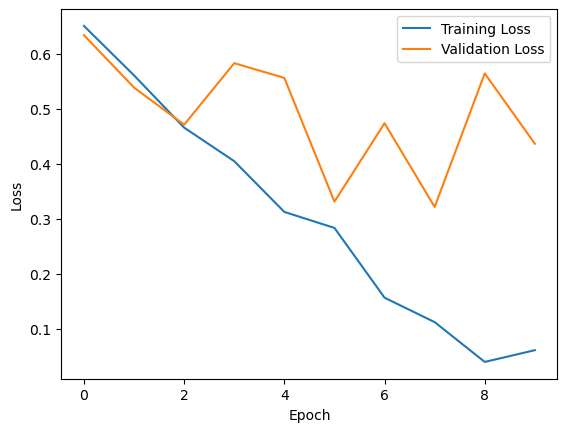

In [40]:
plt.plot(train_loss_list, label="Training Loss")
plt.plot(val_loss_list, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [41]:
model_save_path = './trained models/mci model 85 acc.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to ./trained models/mci model 85 acc.pth
